In [753]:
import pandas as pd
import seaborn as sns
import numpy as np

df = pd.read_csv("Titanic_train.csv")

| col name  | description |details|
| --- | --- | --- |
| survival	| Survival	    |0 = No, 1 = Yes|
| pclass	    | Ticket class	|1 = 1st, 2 = 2nd, 3 = 3rd|
| sex	    | Sex	
| Age	    | Age in years	
| sibsp	    | # of siblings / spouses aboard the Titanic	
| parch	    | # of parents / children aboard the Titanic	
| ticket	    | Ticket number	
| fare	    | Passenger fare	
| cabin	    | Cabin number	
| embarked	| Port of Embarkation	| C = Cherbourg, Q = Queenstown, S = Southampton


So before looking at the data lets see what the columns are all about 

**survivial** is obviously our target variable

**pclass** is the ticket category which could be related to the survival, depending on where certain classes were located in the ship. With no further knowledge a data analysis will show us if it is related

**sex** no comment, categorical feature

**age** might be important because of the fitness of a person or maybe young people like kids and women got rescued more as they say "children and women first (off board)"

**sibsp** is the number of siblings our spouses aboard. It's an interesting feature and can probably be used for feature engineering later

**parch** almost like sibsp, can be probably used as is and for feature engineering. 

**ticketnumber** is probably unrelated, needs to be discussed by maybe analysing certain buckets of numbers towards target variable cor

**fare** interesting feature that shows us price class. Could be similar to pclass, further investigation needs to show if fare is strongly related to pclass and then maybe one of it can be dropped

**cabin** as cabinnumber. has to be investigated if the numbers mean anything or are just sumply aritifial numbers. In the latter case it would be useless and to be droped

**embarked** location of the port. can be indirectly related. maybe some ports embarked more wealthy people or in general a group of people that are likelier to survive than others

In [754]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


First observation is that PassengerId is completely useless, so we drop it. 

Name seems to be useless as well, although it contains maybe information like titles that could be derived from it.

Sex needs to be encoded

Ticketnumber seems to be indeed useless.

Cabin seems to have missing vaues so we need to check if we can impute them somehow

In [755]:
df = df.drop(["Ticket","PassengerId"],axis=1)

In [756]:
df_copy = df.copy()
df_copy["Sex"] = df_copy["Sex"].apply(lambda x: 1 if x == "male" else 0)

from sklearn.preprocessing import LabelEncoder

df_copy = df_copy[df_copy["Embarked"].notnull()]

le = LabelEncoder()
df_copy["Embarked"] = le.fit_transform(df_copy["Embarked"])




For the purpose of correlation analysis I quickly label encoded "Sex" and "Embarked" parameter to see if and how strong the correlate. For the actual data pipeline those will be one-hot-encoded 

In [757]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Name      889 non-null    object 
 3   Sex       889 non-null    int64  
 4   Age       712 non-null    float64
 5   SibSp     889 non-null    int64  
 6   Parch     889 non-null    int64  
 7   Fare      889 non-null    float64
 8   Cabin     202 non-null    object 
 9   Embarked  889 non-null    int64  
dtypes: float64(2), int64(6), object(2)
memory usage: 76.4+ KB


Cabin is only filled for 202 persons so we just drop the feature because its missing for the very majority of our data

In [758]:
df_copy = df_copy.drop(["Cabin"],axis=1)

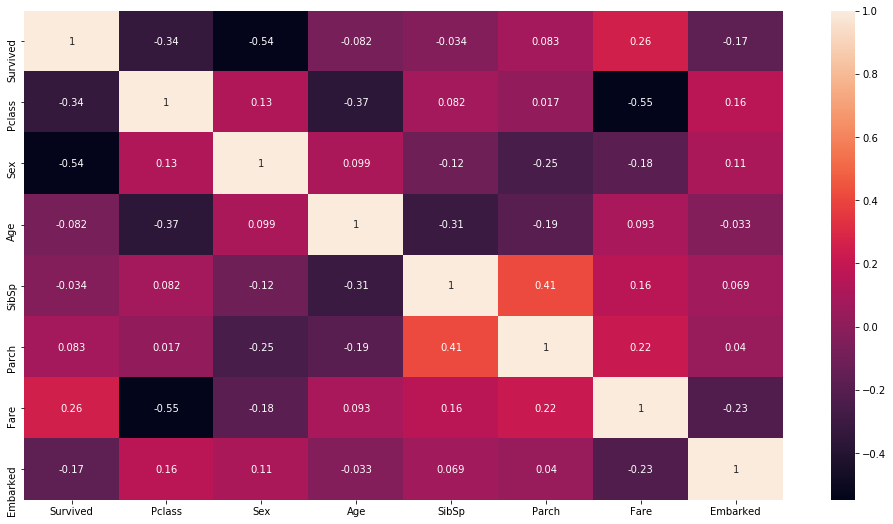

In [759]:
import matplotlib.pyplot as plt
plt.figure(figsize=(17,9))
sns.heatmap(df_copy.corr(),annot=True)

Observations:

* Survived seems to be stronger correlated to fare, Sex, and PClass
* As suspected Pclass has correlations to Fare which is expected because PClass is some kind of bucketing of fares (often)
* Sex is strongest correlated to Survived which is also explainable since women were probably a high priority
* SibSp and Parch are strognly correlated, so we will create a new feature called "Number of Family members" that should reflect both of the features quite well
* The correlation of embarked is not as high as one would think but still it is a usefull information and seems to be related to pclass which is interesting
* Name is not on the plot, but it contains the title of someone so we extract this channeling it into a new feature

In [760]:
####  adding new feature title
def name2Category(name):
    start = name.find(",")
    end = name.find(".")
    return name[start+1:end].strip()


df_copy["Title"] = df_copy.apply(lambda x: name2Category(x["Name"]),axis=1)

#le = LabelEncoder()
#df_copy["Title"] = le.fit_transform(df_copy["Title"])







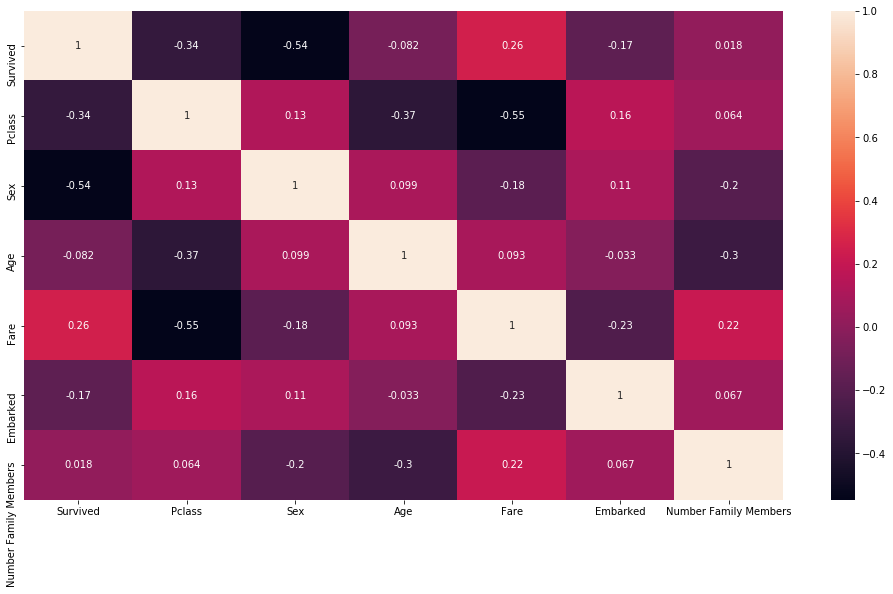

In [761]:
# create new feature "number of family members"

df_copy["Number Family Members"] = df_copy["Parch"] + df_copy["SibSp"]

df_copy = df_copy.drop(["Parch","SibSp"],axis=1)

import matplotlib.pyplot as plt
plt.figure(figsize=(17,9))
sns.heatmap(df_copy.corr(),annot=True)



## EDA of all the features so far

plan:

* find out how balanced the classes are by investigating survived variable
* each feature to be investigated upon its distribution and corrleation to target variable
* Age has missing values but correlates stronger with "Number Family Members", "Title", "PClass"

we will try to impute missing Age numbers with a regression over said 3 features


### handle missing age values

In [762]:
from sklearn.ensemble import RandomForestRegressor

def fillAge(data):

    
    df_ages = data.copy()
    
    df_ages = df_ages[["Pclass","Title","Number Family Members","Sex","Age"]]
    
    df_ages = df_ages.join(pd.get_dummies(df_ages["Title"]))
    df_ages = df_ages.drop(["Title"],axis=1)
    
    df_ages = df_ages.join(pd.get_dummies(df_ages["Pclass"]))
    df_ages = df_ages.drop(["Pclass"],axis=1)
    
    df_ages = df_ages.join(pd.get_dummies(df_ages["Sex"]))
    df_ages = df_ages.drop(["Sex"],axis=1)
    
    
    r = RandomForestRegressor()
    
    df_train = df_ages[df_ages["Age"].notnull()]
    df_test =  df_ages[~df_ages["Age"].notnull()]
    
    X_train, y_train = df_train.drop(["Age"],axis=1), df_train["Age"]
    X_test, _ = df_test.drop(["Age"],axis=1), df_test["Age"]
    
    r = RandomForestRegressor(n_estimators=300,max_depth=100)
    r.fit(X_train, y_train)
    
    data.loc[X_test.index,"Age"] = np.round(r.predict(X_test),0)
    
    
    ## add bracket
    data["AgeBucket"] = data.apply(lambda x: pd.cut([x["Age"]],[0,2,6,12,18,30,40,60,80,100])[0],axis=1)
    
    print(data[data.AgeBucket.isna()])
    
    return data



#### Survived

[1.61470588 1.        ]


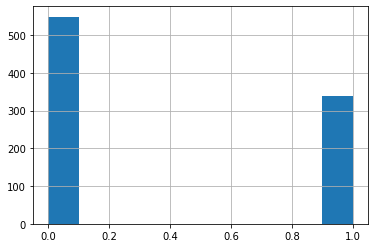

In [763]:
df_copy["Survived"].hist()

survived_distribution = df_copy[["Survived","Sex"]].groupby("Survived").count().values.ravel()
survived_distribution = survived_distribution / survived_distribution[1]
print(survived_distribution)


So the ratio is 1:61 survived to not survived. We need to keep this in mind for when we apply models to it. It might be good to even out the classes by over- or undersampling the data to make the groups more balanced

#### pclass

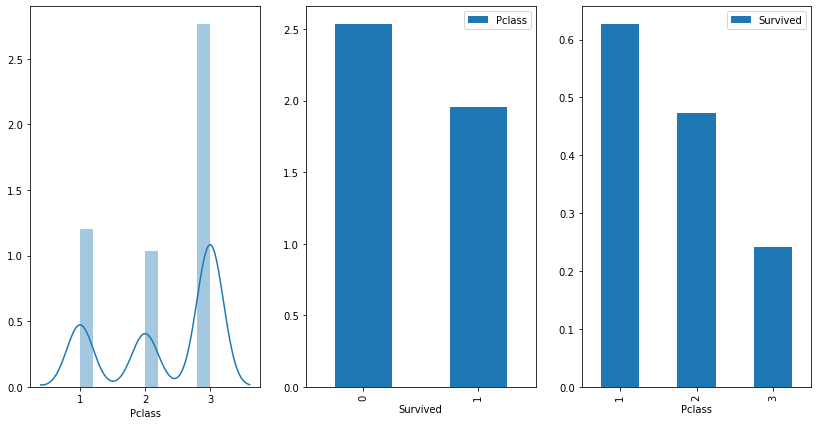

In [764]:

plt.figure(figsize=(14,7))

a = plt.subplot(131)
sns.distplot(df_copy["Pclass"],ax=a)

a = plt.subplot(132)
df_copy[["Survived","Pclass"]].groupby(["Survived"]).mean().plot(ax=a,kind="bar")

a = plt.subplot(133)
df_copy[["Survived","Pclass"]].groupby(["Pclass"]).mean().plot(ax=a,kind="bar")



As seen in fig 1 overall we have a lot more Class 3 Passengers. However class 1 passengers were about 63% sure to survive in contrast to around 25% in class 3 (fig 3)

Overall we value this Parameter having a bigger influence to the target variable

#### Sex

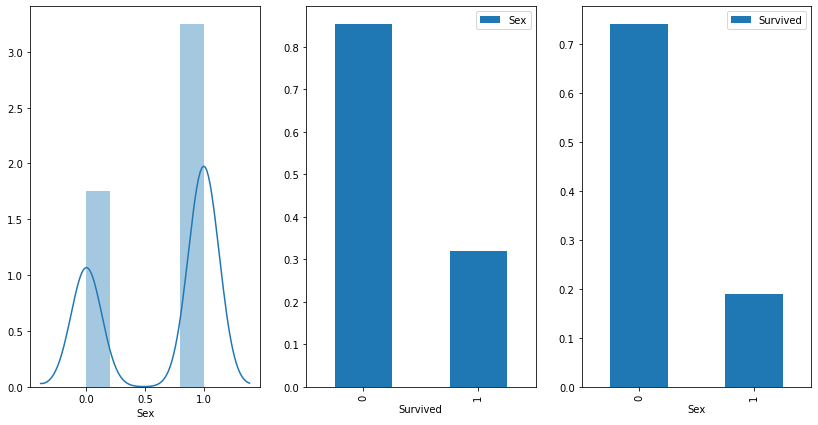

In [765]:

plt.figure(figsize=(14,7))

a = plt.subplot(131)
sns.distplot(df_copy["Sex"],ax=a)

a = plt.subplot(132)
df_copy[["Survived","Sex"]].groupby(["Survived"]).mean().plot(ax=a,kind="bar")

a = plt.subplot(133)
df_copy[["Survived","Sex"]].groupby(["Sex"]).mean().plot(ax=a,kind="bar")



Keeping in mind that Sex 1 means Man and Sex 0 means woman

We seem to have double the amount of men on the ship (fig 1)

Also it was much more likely for women to survive (fig 3). men only had a change ~20% to survive.
So this seems to be a very strong indicator.

#### Age

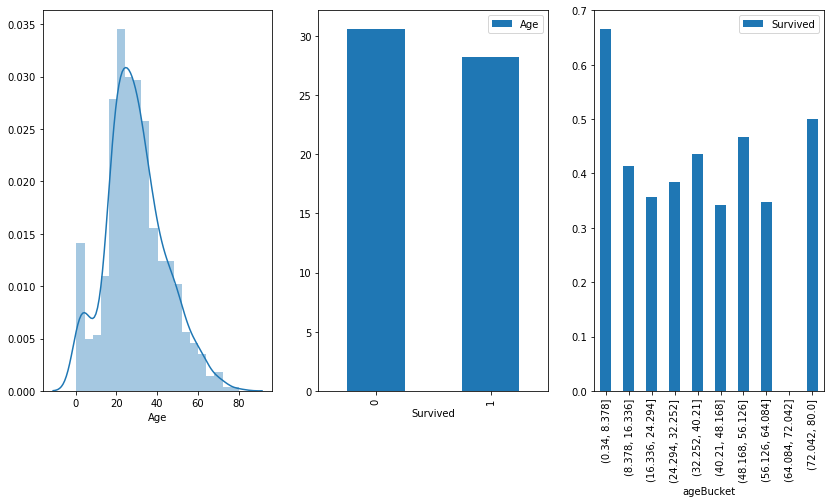

In [766]:

plt.figure(figsize=(14,7))

a = plt.subplot(131)
sns.distplot(df_copy["Age"],ax=a)

a = plt.subplot(132)
df_copy[["Survived","Age"]].groupby(["Survived"]).mean().plot(ax=a,kind="bar")

a = plt.subplot(133)

# create buckets for age 
df_temp = df_copy.copy()

df_temp["ageBucket"] = pd.cut(df_temp["Age"],10)

df_temp[["Survived","ageBucket"]].groupby(["ageBucket"]).mean().plot(ax=a,kind="bar")



Overall its visible that the Age is a normal distribution with a skew to the right. Furtheremore we seem to have a lot of lids with age 0 on board. This was probably used for babys. (fig 1)

The average survivors age is not very different from the average dead person as seen in fig 2

Bucketing the ages we can see that a lot of infants survived but the rest of the people seem to have almost a 50/50 chance of surviving. People older than 72 are a bit more likely to survive.

Probably this is still a good feature combined with gender, so we keep it. Just a look at the age distribution at age 0 is up because it is actually disturbing the normal distribution

In [767]:
df_temp[df_temp["Age"] < 4]

,Survived,Pclass,Name,Sex,Age,Fare,Embarked,Title,Number Family Members,ageBucket
7,0,3,"Palsson, Master. Gosta Leonard",1,2.00,21.0750,2,Master,4,"(0.34, 8.378]"
16,0,3,"Rice, Master. Eugene",1,2.00,29.1250,1,Master,5,"(0.34, 8.378]"
43,1,2,"Laroche, Miss. Simonne Marie Anne Andree",0,3.00,41.5792,0,Miss,3,"(0.34, 8.378]"
78,1,2,"Caldwell, Master. Alden Gates",1,0.83,29.0000,2,Master,2,"(0.34, 8.378]"
119,0,3,"Andersson, Miss. Ellis Anna Maria",0,2.00,31.2750,2,Miss,6,"(0.34, 8.378]"
164,0,3,"Panula, Master. Eino Viljami",1,1.00,39.6875,2,Master,5,"(0.34, 8.378]"
172,1,3,"Johnson, Miss. Eleanor Ileen",0,1.00,11.1333,2,Miss,2,"(0.34, 8.378]"
183,1,2,"Becker, Master. Richard F",1,1.00,39.0000,2,Master,3,"(0.34, 8.378]"
193,1,2,"Navratil, Master. Michel M",1,3.00,26.0000,2,Master,2,"(0.34, 8.378]"
205,0,3,"Strom, Miss. Telma Matilda",0,2.00,10.4625,2,Miss,1,"(0.34, 8.378]"


Nothing unusual here, seems we had justa lot of 2 year old. It's probably rounding from years 2 on and before its using more granular age when the age is < 1. A thought here could be to normalize age <1 to 0 to not have the gaps in the ages

In [768]:
df_copy["Age"] = df_copy["Age"].apply(lambda x: 0 if x < 1 else x)

#### Fare

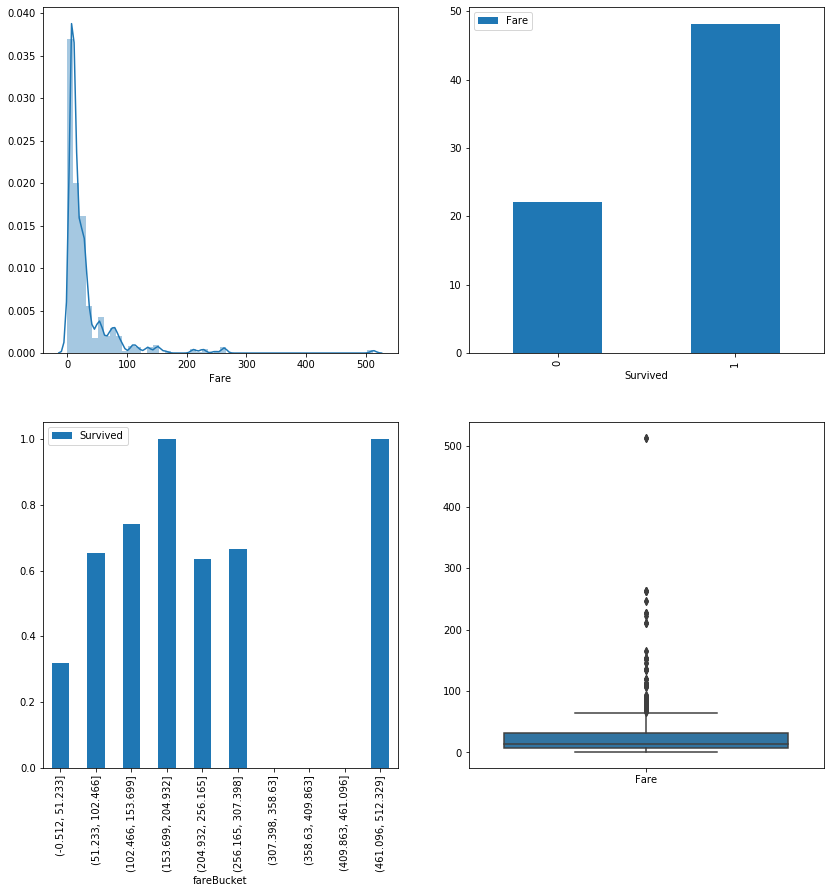

In [769]:

plt.figure(figsize=(14,14))

a = plt.subplot(221)
sns.distplot(df_copy["Fare"],ax=a)

a = plt.subplot(222)
df_copy[["Survived","Fare"]].groupby(["Survived"]).mean().plot(ax=a,kind="bar")

a = plt.subplot(223)

# create buckets for Fare 
df_temp = df_copy.copy()

df_temp["fareBucket"] = pd.cut(df_temp["Fare"],10)

df_temp[["Survived","fareBucket"]].groupby(["fareBucket"]).mean().plot(ax=a,kind="bar")


a = plt.subplot(224)
sns.boxplot(data=df_copy[["Fare"]],ax=a)



First all, the majority of tickets seem to be < 20 $. (fig 4, fig 1), therefore a lot of these extrem high values of 500 or between 100 and 300 are outliers.

In general the average survivor paid almost double the price than the average dead person. (fig 2).

Also certain price ranges have 100\% survivability

the 500 outlier will be filtered however because it seems to be one data point that will completely useless for us and indeed is a outlier

In [770]:
df_copy[df_copy["Fare"] > 300]

# actuall its 3 people who have the highsest fare, so we remove them because there are an exception and don't represent the data set very well

df_copy = df_copy[df_copy["Fare"] < 300]

#### Embarked

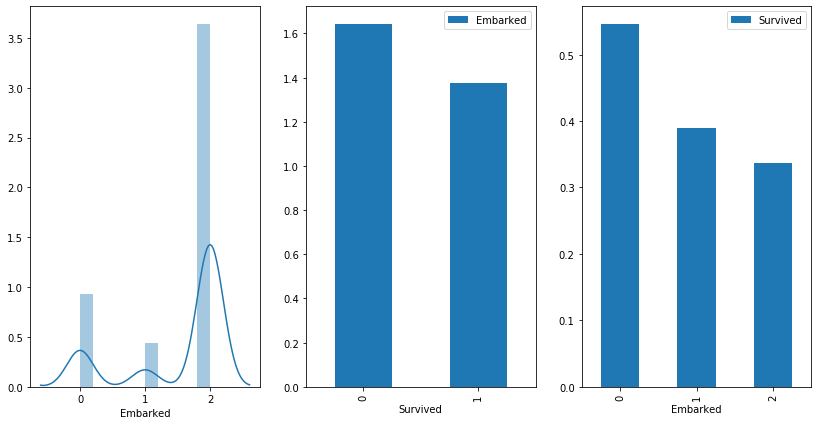

In [771]:

plt.figure(figsize=(14,7))

a = plt.subplot(131)
sns.distplot(df_copy["Embarked"],ax=a)

a = plt.subplot(132)
df_copy[["Survived","Embarked"]].groupby(["Survived"]).mean().plot(ax=a,kind="bar")

a = plt.subplot(133)

df_copy[["Survived","Embarked"]].groupby(["Embarked"]).mean().plot(ax=a,kind="bar")




First we notice that there a lot of members embarqued in 2.

People embarqued in 0 were around 10% more likely to survive.

We leave this feature as it is.

#### Number of (other) Familiy Member 

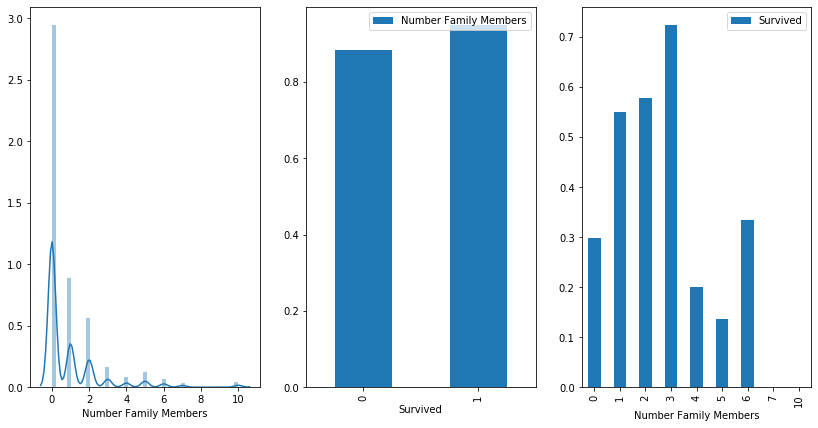

In [772]:

plt.figure(figsize=(14,7))

a = plt.subplot(131)
sns.distplot(df_copy["Number Family Members"],ax=a)

a = plt.subplot(132)
df_copy[["Survived","Number Family Members"]].groupby(["Survived"]).mean().plot(ax=a,kind="bar")

a = plt.subplot(133)

df_copy[["Survived","Number Family Members"]].groupby(["Number Family Members"]).mean().plot(ax=a,kind="bar")




Most people have no other family member on board. 

People with 3 other family members have a 70% to survive, whilst People with 0 family members have only a 30% of survival.

But overall the average survivor had around 1 family member on board while the average dead person had .9. so its not that influencale 

## Models

In [773]:
# last check for null values

accuracy_map = {}

df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 886 entries, 0 to 890
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Survived               886 non-null    int64  
 1   Pclass                 886 non-null    int64  
 2   Name                   886 non-null    object 
 3   Sex                    886 non-null    int64  
 4   Age                    709 non-null    float64
 5   Fare                   886 non-null    float64
 6   Embarked               886 non-null    int64  
 7   Title                  886 non-null    object 
 8   Number Family Members  886 non-null    int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 69.2+ KB


In [774]:
# First create a Pipeline reflecting all our changes done manually in the above 
# to be able to redo this with test data or new data in general
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score


class AddNewFeature(BaseEstimator, TransformerMixin):
    def __init__(self, colname, formula):
        self.colname = colname
        self.formula = formula
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X[self.colname] = X.apply(self.formula, axis=1)
        return X
    
class ColSelector(BaseEstimator, TransformerMixin):
    def __init__(self, collist):
        self.collist = collist
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.collist]

class RowSelector(BaseEstimator, TransformerMixin):
    def __init__(self, condition):
        self.condition = condition
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[X.apply(self.condition,axis=1)]

    
# create Pipelines



numerical_features = ["Number Family Members", "Fare", "Age"]
caterogical_features = ["Pclass","Sex","Embarked","Title","AgeBucket","Cabin"]

def name2Category(name):
    start = name.find(",")
    end = name.find(".")
    return name[start+1:end].strip()


df_copy["Title"] = df_copy.apply(lambda x: name2Category(x["Name"]),axis=1)


filtering_Pipeline = Pipeline([
    ("setEmbarkedToOther", AddNewFeature("Embarked", lambda x: "other" if pd.isnull(x["Embarked"])  else x["Embarked"])),
    #("fixAge", AddNewFeature("Age", lambda x: np.round(x["Age"],0) )),
    ("familyMemberFeature", AddNewFeature("Number Family Members", lambda x: x["SibSp"] + x["Parch"])),
    ("addTitle", AddNewFeature("Title", lambda x: name2Category(x["Name"]))),
    ("setCabinToXifNull", AddNewFeature("Cabin", lambda x: 'X' if pd.isnull(x["Cabin"]) else x["Cabin"][:1]))
]) 

from sklearn.impute import SimpleImputer

numerical_Pipeline = Pipeline([
    #("cleaning", filtering_Pipeline),
    ("filter" , ColSelector(numerical_features)),
    ("imputer", SimpleImputer()),
    ("scaler", StandardScaler())
])


categorical_Pipeline = Pipeline([
    #("cleaning", filtering_Pipeline),
    ("filter" , ColSelector(caterogical_features)),
    ("scaler", OneHotEncoder(handle_unknown="ignore"))
])

full_Pipeline = FeatureUnion([
    ("numerical", numerical_Pipeline),
    ("categorical", categorical_Pipeline)
])



## cleaning 
### first clean age by interpolating with model

df_cleaned = filtering_Pipeline.fit_transform(df)
df_cleaned = fillAge(df_cleaned)


# Seperate target from features 
X = df_cleaned[["Pclass","Sex","Age","SibSp","Parch","Fare","Embarked","Number Family Members","Title","Cabin","AgeBucket"]]

y = df_cleaned["Survived"]



X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2)




Empty DataFrame
Columns: [Survived, Pclass, Name, Sex, Age, SibSp, Parch, Fare, Cabin, Embarked, Number Family Members, Title, AgeBucket]
Index: []


In [775]:
X_train[X_train.AgeBucket.isna()]

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Number Family Members,Title,Cabin,AgeBucket


### Random Forest

In [776]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score


rf_pipe = Pipeline([
    ("dataprep", full_Pipeline),
    ("rf",RandomForestClassifier())
])

# do baseline evaluation

scores = cross_val_score(rf_pipe,X_train,y_train, cv=5, n_jobs=4, verbose=5, scoring="f1")
print(np.abs(scores), np.abs(np.mean(scores)))

# Baseline is 0.7700623775994024 [0.74725275 0.73333333 0.79069767 0.82608696 0.75294118]

# do gridsearch
#parameters = {
#    "rf__n_estimators": [10,50,100,150],
#    "rf__max_depth": [8,16,32,64,128,None]
#}

#clf = GridSearchCV(rf_pipe, parameters,cv=5,scoring="f1",verbose=1)
#clf.fit(X_train,y_train)
#print(clf.best_params_)
#{'rf__max_depth': 64, 'rf__n_estimators': 150}

rf_pipe[1].max_depth=64
rf_pipe[1].n_estimators=150

#takeover scores as final scores
#scoremap["Random Forest"] = np.abs(scores)

rf_pipe.fit(X_train,y_train)
predictions = rf_pipe.predict(X_test)

f1 = f1_score(y_test,predictions)
acc = accuracy_score(y_test, predictions)


print("Test Set", f1, acc)
print("Train Set", np.mean(cross_val_score(rf_pipe, X_train, y_train, cv=5, n_jobs=4, scoring="f1")), np.mean(cross_val_score(rf_pipe, X_train, y_train, cv=5, n_jobs=4, scoring="accuracy")))
#test_scores["Random Forest"] = mae


# last cross validation on all of the training data
lastCross = cross_val_score(rf_pipe,X,y, cv=5, n_jobs =4, scoring="accuracy")
print("LastCross", lastCross)
accuracy_map["random forest"] = lastCross


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    3.2s remaining:    4.8s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    4.0s finished


[0.74782609 0.65420561 0.80357143 0.76635514 0.75438596] 0.7452688456207566
Test Set 0.6935483870967741 0.7877094972067039
Train Set 0.7376686003851096 0.804855707672609
LastCross [0.82681564 0.78651685 0.83707865 0.76966292 0.83146067]


### SVM

In [777]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score


svm_pipe = Pipeline([
    ("dataprep", full_Pipeline),
    ("svm",SVC())
])

# do baseline evaluation

scores = cross_val_score(svm_pipe,X_train,y_train, cv=5, n_jobs=4, verbose=5, scoring="f1")
print(np.abs(scores), np.abs(np.mean(scores)))

# do gridsearch
#parameters = {
#    "svm__C": [0.001, 0.01, 0.1, 1, 10, 100],
#    "svm__kernel": ["linear","rbf"]
#}

#clf = GridSearchCV(svm_pipe, parameters,cv=5,scoring="f1",verbose=1)
#clf.fit(X_train,y_train)
#print(clf.best_params_)
#{'svm__C': 1, 'svm__kernel': 'rbf'}

svm_pipe[1].C=1
svm_pipe[1].kernel="rbf"

#takeover scores as final scores
#scoremap["Random Forest"] = np.abs(scores)

svm_pipe.fit(X_train,y_train)
predictions = svm_pipe.predict(X_test)

f1 = f1_score(y_test,predictions)
acc = accuracy_score(y_test,predictions)

print("Test Set", f1, acc)
print("Train Set", np.mean(cross_val_score(svm_pipe, X_train, y_train, cv=5, n_jobs=4, scoring="f1")),np.mean(cross_val_score(svm_pipe, X_train, y_train, cv=5, n_jobs=4, scoring="accuracy")))
#test_scores["Random Forest"] = mae

# last cross validation on all of the training data
lastCross = cross_val_score(svm_pipe,X,y, cv=5, n_jobs =4, scoring="accuracy")
print("LastCross", lastCross)
accuracy_map["svm"] = lastCross

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.3s finished


[0.8        0.75229358 0.7962963  0.79245283 0.83928571] 0.7960656837504683
Test Set 0.672 0.770949720670391
Train Set 0.7960656837504683 0.8455431892051608
LastCross [0.84916201 0.82022472 0.8258427  0.80898876 0.87078652]


### Gradient Boost

In [778]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, accuracy_score


gb_pipe = Pipeline([
    ("dataprep", full_Pipeline),
    ("xbg",GradientBoostingClassifier())
])

# do baseline evaluation

scores = cross_val_score(gb_pipe,X_train,y_train, cv=5, n_jobs=4, verbose=5, scoring="f1")
print(np.abs(scores), np.abs(np.mean(scores)))

# do gridsearch
parameters = {
    #"xbg__min_samples_split": np.linspace(0.1, 0.5, 12),
    #"xbg__min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "xbg__max_depth":[8,16,32,64,128],
    #"xbg__max_features":["log2","sqrt"],
    #"xbg__criterion": ["friedman_mse",  "mae"],
    "xbg__learning_rate":[0.15,0.1,0.05,0.01,0.005,0.001],
    "xbg__n_estimators":[10,100,1000]
    }

clf = GridSearchCV(gb_pipe, parameters,cv=5,scoring="f1",verbose=5)
#clf.fit(X_train,y_train)
#print(clf.best_params_)
#xbg__learning_rate=0.05, xbg__max_depth=8, xbg__n_estimators=100

gb_pipe[1].max_depth=8
gb_pipe[1].n_estimators=100
gb_pipe[1].learning_rate=0.05


#takeover scores as final scores
#scoremap["Gradient Boost"] = np.abs(scores)

gb_pipe.fit(X_train,y_train)
predictions = gb_pipe.predict(X_test)

f1 = f1_score(y_test,predictions)
acc = accuracy_score(y_test,predictions)

print("Test Set", f1, acc)
print("Train Set", np.mean(cross_val_score(gb_pipe, X_train, y_train, cv=5, n_jobs=4, scoring="f1")),np.mean(cross_val_score(gb_pipe, X_train, y_train, cv=5, n_jobs=4, scoring="accuracy")))
#test_scores["Gradient Boost"] = mae

# last cross validation on all of the training data
lastCross = cross_val_score(gb_pipe,X,y, cv=5, n_jobs =4, scoring="accuracy")
print("LastCross", lastCross)
accuracy_map["gradient Boost"] = lastCross

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.8s finished


[0.82568807 0.72222222 0.80733945 0.74509804 0.81081081] 0.7822317190368999
Test Set 0.6825396825396826 0.776536312849162
Train Set 0.7474128666158066 0.7992120555500838
LastCross [0.80446927 0.78089888 0.83146067 0.78651685 0.7752809 ]


### FNN

In [779]:
from tensorflow import keras
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical
from functools import reduce

X_train_2 = full_Pipeline.fit_transform(X_train)

X_test_2 = full_Pipeline.transform(X_test)
y_train_2 = to_categorical(y_train)

y_test_2 = to_categorical(y_test)

lrcallback = ReduceLROnPlateau(factor=0.1, patience=0, monitor='loss',verbose=False)
estop = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True,verbose=False)

def fnn(input_shape):
    model = Sequential()
    model.add(Dense(50, input_shape=(input_shape,),activation='relu'))
    model.add(Dropout(.2))
    model.add(Dense(20, activation='relu'))
    model.add(Dropout(.2))
    model.add(Dense(2, activation="softmax"))

    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["acc",keras.metrics.Recall(),keras.metrics.Precision()])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["acc",keras.metrics.Recall(),keras.metrics.Precision()])
    return model




kfold = 5

indices = np.array(range(X_train_2.shape[0]))
np.random.shuffle(indices)

# split it into n chunks
accuarcies = []
splitted = np.array_split(indices, 5)

for i in range(len(splitted)):
    temp_test_X = X_train_2[splitted[i],:]
    temp_test_y = y_train_2[splitted[i],:]
    
    
    otherArray =  []
    otherIndexes = [j for j in range(len(splitted)) if i!=j]
    
    for j in otherIndexes:
        otherArray = otherArray + splitted[j].tolist()
    
    train_ind = otherArray
    
    temp_train_X = X_train_2[train_ind,:]
    temp_train_y = y_train_2[train_ind,:]
    
    net = fnn(X_train_2.shape[1])
    
    net.fit(temp_train_X, temp_train_y,epochs = 100, batch_size=1, verbose=False, callbacks=[lrcallback, estop])
    evalObj = net.evaluate(temp_test_X, temp_test_y)
    print(evalObj)
    accuarcies.append(evalObj[1])
    
print("Accuarcy for Net", np.mean(np.array(accuarcies)), accuarcies)
accuracy_map["FNN"] = accuarcies


143/143 [==============================] - 0s 786us/step
[0.3658098447156119, 0.8601398468017578, 0.8448635339736938, 0.8448635339736938]
143/143 [==============================] - 0s 696us/step
[0.24794120617679782, 0.9230769276618958, 0.8230332136154175, 0.8230332136154175]
142/142 [==============================] - 0s 522us/step
[0.5379480958824426, 0.7676056623458862, 0.8639674186706543, 0.8639674186706543]
142/142 [==============================] - 0s 779us/step
[0.4943607147310821, 0.8239436745643616, 0.8610746264457703, 0.8610746264457703]
142/142 [==============================] - 0s 810us/step
[0.3806054869168241, 0.8380281925201416, 0.849288821220398, 0.849288821220398]
Accuarcy for Net 0.8425588607788086 [0.8601398468017578, 0.9230769276618958, 0.7676056623458862, 0.8239436745643616, 0.8380281925201416]


## Result

Lets create a submission for the competition

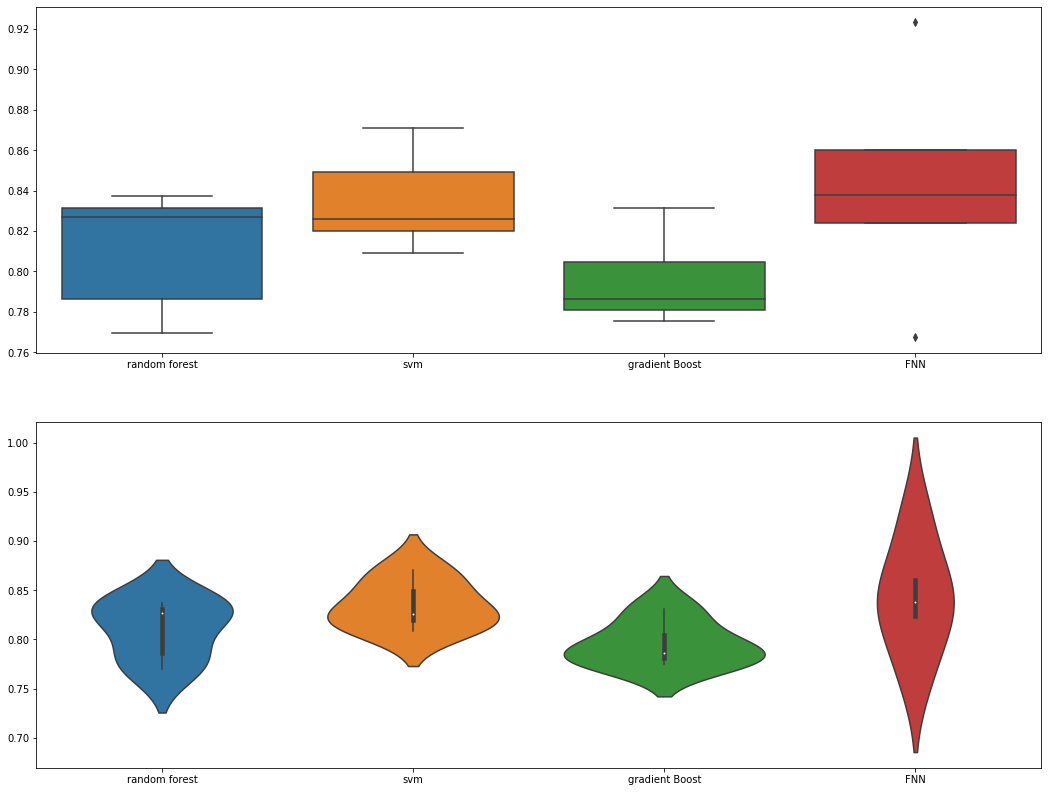

In [780]:
plt.figure(figsize=(18,14))

a = plt.subplot(211)
sns.boxplot(data=pd.DataFrame.from_dict(accuracy_map),ax=a)

a = plt.subplot(212)
sns.violinplot(data=pd.DataFrame.from_dict(accuracy_map),ax=a)

In [781]:
import pandas as pd
dftest = pd.read_csv("Titanic_test.csv")



In [782]:
## we need to alter a bit the pipeline because we cannot just cross out data here
from sklearn.pipeline import Pipeline

print(dftest.shape)

df_test_cleaned = filtering_Pipeline.fit_transform(dftest)
df_test_cleaned = fillAge(df_test_cleaned)



# Seperate target from features 
X_test = df_test_cleaned[["Pclass","Sex","Age","SibSp","Parch","Fare","Embarked","Number Family Members","Title","AgeBucket","Cabin"]]

#y = df_test_cleaned["Survived"]

X_nn = full_Pipeline.fit_transform(X)
y_nn = to_categorical(y)

net = fnn(X_nn.shape[1])
net.fit(X_nn, y_nn,epochs = 100, batch_size=1, verbose=False, callbacks=[lrcallback, estop])


(418, 11)
Empty DataFrame
Columns: [PassengerId, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked, Number Family Members, Title, AgeBucket]
Index: []


In [783]:
X_test_2 = full_Pipeline.transform(X_test)
print(X_test_2.shape, X_nn.shape)

results = []

for prediction in net.predict(X_test_2):
    results.append(np.argmax(prediction))
    
len(results)

dfout = pd.DataFrame.from_dict({
    "PassengerId": dftest["PassengerId"],
    "Survived":results
})

dfout.to_csv("Titanic_submission_nn.csv",index=False)

(418, 46) (891, 46)


In [786]:
svm_pipe.fit(X,y)
results = svm_pipe.predict(X_test)

dfout = pd.DataFrame.from_dict({
    "PassengerId": dftest["PassengerId"],
    "Survived":results
})

dfout.to_csv("Titanic_submission_svm.csv",index=False)